### Display delta values over time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


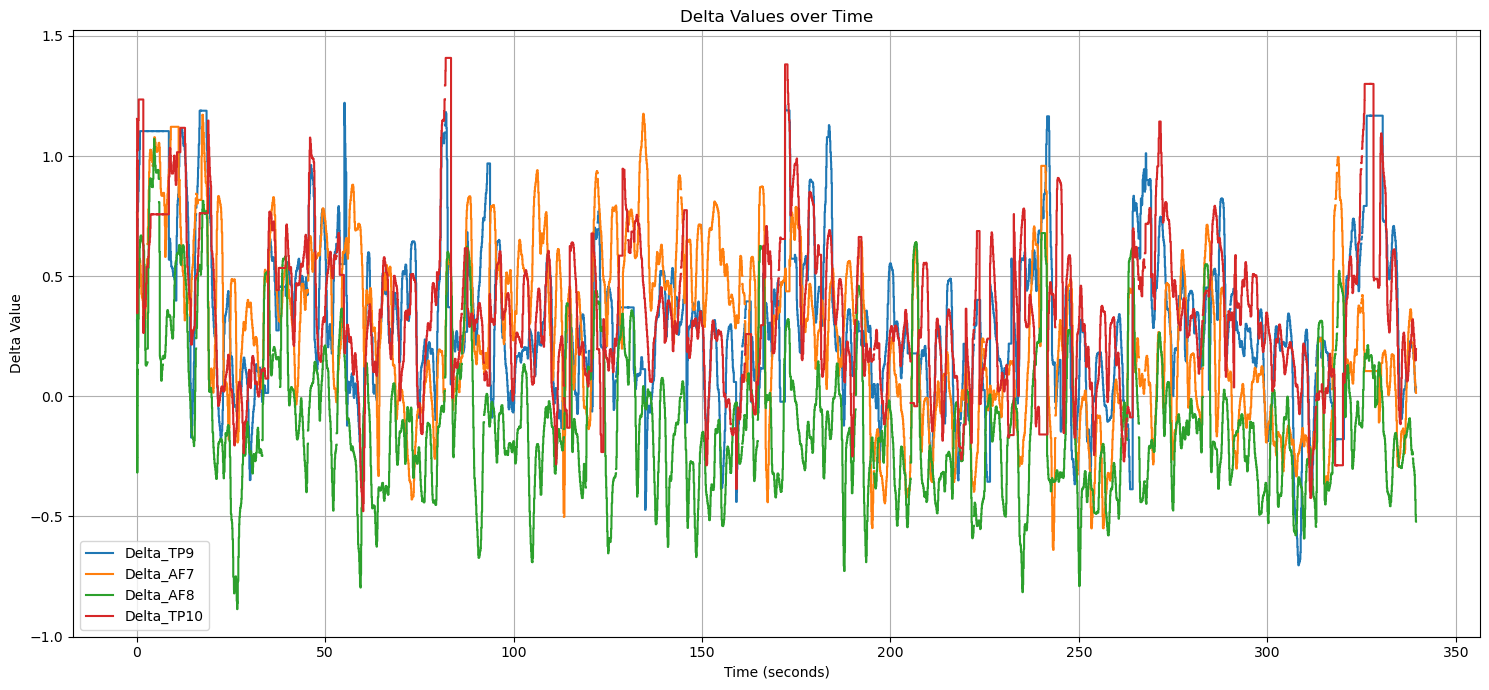

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the filename is "data.csv"
df = pd.read_csv("../data/5min_256Hz_17:11:23.csv")

# Convert the 'TimeStamp' column to datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# Calculate seconds from the start of the dataframe
df['Seconds'] = (df['TimeStamp'] - df['TimeStamp'].iloc[0]).dt.total_seconds()

# Filter out rows with missing values for Delta columns
#df = df.dropna(subset=['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10'])

# Plotting Delta values with seconds on the x-axis
plt.figure(figsize=(15, 7))
for column in ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10']:
    plt.plot(df['Seconds'], df[column], label=column)

plt.title("Delta Values over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Delta Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Extract features for delta values

### Import packages & load data

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import mne
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../data/5min_256Hz_17:11:23.csv')

In [16]:
# first glance
data.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2023-11-17 09:37:56.372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected Muse-AB4C
1,2023-11-17 09:37:56.451,0.316438,0.948555,0.766601,1.154738,-0.153094,0.388197,0.431739,0.71507,0.398981,...,6.25061,-3.132782,-0.687866,1.0,1.0,1.0,1.0,1.0,45.0,NaN
2,2023-11-17 09:37:56.452,0.316438,0.948555,0.766601,1.154738,-0.153094,0.388197,0.431739,0.71507,0.398981,...,6.25061,-3.132782,-0.687866,1.0,1.0,1.0,1.0,1.0,45.0,NaN
3,2023-11-17 09:37:56.452,0.316438,0.948555,0.766601,1.154738,-0.153094,0.388197,0.431739,0.71507,0.398981,...,6.25061,-3.132782,-0.687866,1.0,1.0,1.0,1.0,1.0,45.0,NaN
4,2023-11-17 09:37:56.453,0.316438,0.948555,0.766601,1.154738,-0.153094,0.388197,0.431739,0.71507,0.398981,...,6.25061,-3.132782,-0.687866,1.0,1.0,1.0,1.0,1.0,45.0,NaN


In [17]:
df.shape

(87326, 40)

### Calculate features

In [18]:
# TODO: handle missing values in a better fashion (interpolation?)
data = data.dropna(subset=['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10'])

In [19]:
# Custom function to calculate approximate entropy
def approximate_entropy(segment, m=2, r=None):
    if not r:
        r = 0.2 * np.std(segment)
    
    def phi(m):
        x = np.array([segment[j:j+m] for j in range(len(segment) - m + 1)])
        C = np.sum([np.sum(np.abs(x - x[i]) <= r, axis=1) / (len(segment) - m + 1) for i in range(len(segment) - m + 1)], axis=0) / (len(segment) - m + 1)
        return np.sum(np.log(C)) / (len(segment) - m + 1)
    
    return np.abs(phi(m) - phi(m + 1))

In [20]:
# Define the segment size
segment_size = int(0.8 * 256) # this is 204 which is 0.796875 seconds

# Create empty lists to store our results
approx_entropy = []
total_variation = []
standard_variation = []
energy = []
sample_skewness = []

for i in range(0, len(data), segment_size):
    segment = data['Delta_TP9'].iloc[i:i+segment_size]
    
    if len(segment) < segment_size: break
    segment = segment.reset_index(drop=True)

    # Approximate Entropy
    approx_entropy.append(approximate_entropy(segment))
    
    # Total Variation
    total_variation.append(np.sum(np.gradient(segment)))
    
    # Standard Variation (Standard Deviation)
    standard_variation.append(np.std(segment))
    
    # Energy
    energy.append(np.sum(segment**2))
    
    # Skewness
    sample_skewness.append(skew(segment))

# You can now convert these lists into a DataFrame
features_df = pd.DataFrame({
    'Approx. Entropy': approx_entropy,
    'Total variation': total_variation,
    'Standard variation': standard_variation,
    'Energy': energy,
    'Skewness': sample_skewness
})

/var/folders/vn/vg9g17yx0hgcwsgfx9z89kpc0000gn/T/ipykernel_80883/206523985.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sample_skewness.append(skew(segment))


In [23]:
print(features_df.shape)
print(features_df.head())

(427, 5)
   Approx. Entropy  Total variation  Standard variation      Energy  Skewness
0         0.000373        -0.095241        4.067246e-02   11.882099  0.504688
1         0.001332         0.516195        1.646693e-01   67.886096 -0.701215
2         0.000928         0.366405        1.212623e-01  173.023890  0.230345
3         0.000000         0.000000        4.440892e-15  248.547333       NaN
4         0.000000         0.000000        4.440892e-15  248.547333       NaN


### Add previous windows (context for time series)

In [24]:
def add_windows(feature_df, num_windows=9):
    new_features = []

    for i in range(len(feature_df)):
        current_window = feature_df.iloc[i]
        if i < num_windows:
            previous_windows = pd.DataFrame(index=range(num_windows - i), columns=feature_df.columns)
            previous_windows = previous_windows.fillna(0)
            previous_windows = pd.concat([previous_windows, feature_df.iloc[:i]])
        else:
            previous_windows = feature_df.iloc[i - num_windows:i]
        concatenated_features = pd.concat([current_window, previous_windows.unstack()]).reset_index(drop=True)
        new_features.append(concatenated_features)
    
    return pd.DataFrame(new_features)

new_df = add_windows(features_df)

In [26]:
print(new_df.shape)
print(new_df.head())

(427, 50)
         0         1             2           3         4    5    6    7    8   \
0  0.000373 -0.095241  4.067246e-02   11.882099  0.504688  0.0  0.0  0.0  0.0   
1  0.001332  0.516195  1.646693e-01   67.886096 -0.701215  0.0  0.0  0.0  0.0   
2  0.000928  0.366405  1.212623e-01  173.023890  0.230345  0.0  0.0  0.0  0.0   
3  0.000000  0.000000  4.440892e-15  248.547333       NaN  0.0  0.0  0.0  0.0   
4  0.000000  0.000000  4.440892e-15  248.547333       NaN  0.0  0.0  0.0  0.0   

    9   ...          40   41   42   43   44   45        46        47  \
0  0.0  ...    0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
1  0.0  ...   11.882099  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
2  0.0  ...   67.886096  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
3  0.0  ...  173.023890  0.0  0.0  0.0  0.0  0.0  0.000000  0.504688   
4  0.0  ...  248.547333  0.0  0.0  0.0  0.0  0.0  0.504688 -0.701215   

         48        49  
0  0.000000  0.000000  
1  0.000000  0.504688 